### Notebook that creates a classifier to predict the degron-likeness of a particular motif. It also performs its evaluation. 
- First it creates a training set. The TP set is composed by the annotated degrons. TN set is a randomly selected set of random motifs from the simulated dataset. 
- Given the training set it trains a Random Forest Classifier and evaluates it using a  10 bootstrapping of 5-fold CV. 
- Results:
- Visualizes the mean +/- std of AUCs (Fig 1c)
- Feature importance using the RFC ?? (Fig S1c)
- Precision/Recall curve for different thresholds (Fig S1d)




In [60]:
import pandas as pd
import os
import numpy as np
import re
from random import randint
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  precision_recall_fscore_support
from scipy import interp
from sklearn.externals import joblib

### set seed

In [61]:
random_state=np.random.RandomState(seed=0)

### paths

In [62]:
base="../" 

uniprot = os.path.join(base,"data/uniprot_isoforms.tsv")
sequences = os.path.join(base,"data/sequences_isoforms.tsv")

path_output_classes = os.path.join(base,"data/degron_classes.tsv")
path_output_instances = os.path.join(base,"data/degron_instances.tsv")

path_simulated_protein = os.path.join(base,"data","simulated_degrons_proteins.tsv.gz")
path_simulated_random = os.path.join(base,"data","simulated_degrons.tsv.gz") 

path_properties_annotated = os.path.join(base,"data","annotated_degrons_properties.tsv")

script_features = "./pipeline_calculate_features.sh"

type_simulations = "all"

path_output_plots = os.path.join(base,"plots","Figure1")

output_classifier_random  = os.path.join(base,"data","classifier_random.pickle")
output_classifier_protein = os.path.join(base,"data","classifier_protein.pickle")


### Define simulated dataset

In [63]:
if type_simulations == "all":
    simulated = path_simulated_random
else:
    simulated = path_simulated_protein

### Definition of covariates

In [64]:
covariates =["ASA_SCORE","DSS_SCORE","FCONS_SCORE","COIL","ANCHOR_SCORE","nflanking_ptms","nflanking_ub_lysines","HELIX","STRAND","RIG_SCORE","Domain_pfam"]
covariates_names = {"Z_ASA":"S.A.","Z_FCONS":"FCONS","Z_SS_C":"COIL","Z_SS_H":"HELIX","Z_SS_E":"SHEET","Z_DSS":"DISORDER","Z_RIG":"RIGIDITY","Z_ANCHOR":"ANCHOR","Z_DOMAIN":"DOMAIN","Z_FLANKING_UB_LYSINE":"UB_SITES","Z_PTMS":"PHOSPHO_SITES"}
response_var = "IS_DEGRON"

In [65]:
len(covariates)

11

### Definition of training set

##### Load degron data (positive training)

In [66]:
df_annotated_instances = pd.read_csv(path_properties_annotated,sep="\t")
positives = df_annotated_instances[covariates]                    
positives[response_var] = 1.0

/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


##### Load simulated data (negative training)

In [67]:
df_simulated = pd.read_csv(simulated,sep="\t",compression="gzip")
df_simulated = df_simulated[df_simulated["CONS_SCORE"]>0]
df_simulated=df_simulated.dropna(axis=0)

##### Create a balanced dataset (equal number of degrons than negatives)

##### Option a) using motifs from the same protein

In [68]:
N = positives.shape[0]
seleted_rows = []
for index,row in df_annotated_instances.iterrows():
    sims = df_simulated[df_simulated["Entry_Isoform"]==row["Entry_Isoform"]]
    if sims.shape[0] == 0: # If not random are found use one completely random
        seleted_rows.append(df_simulated.sample(n=1,random_state=random_state))
    else:
        seleted_rows.append(sims.sample(n=1,random_state=1))
df_negatives_protein = pd.concat(seleted_rows)

##### Option b) completely random 

In [69]:
N = positives.shape[0]
seleted_rows = []
for index,row in df_annotated_instances.iterrows():
    seleted_rows.append(df_simulated.sample(n=1,random_state=random_state))
df_negatives_random = pd.concat(seleted_rows)

### Create the dataset and train the classifier

##### Same protein

In [70]:
negatives = df_negatives_protein[covariates]                    
negatives[response_var] = 0.0
table_protein = pd.concat([positives,negatives])
table_protein.reset_index(inplace=True,drop=True)
table_protein.dropna(how="any",axis=0,inplace=True)
clf_protein = RandomForestClassifier(n_estimators=10000, random_state=random_state)
clf_protein.fit(table_protein[covariates], table_protein[response_var])
table_protein.shape

/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


(360, 12)

In [71]:
joblib.dump(clf_protein, output_classifier_protein) 

['/workspace/projects/ubiquitins/codereview/degradation/data/classifier_protein.pickle']

##### Different protein

In [72]:
negatives = df_negatives_random[covariates]                    
negatives[response_var] = 0.0
table_random = pd.concat([positives,negatives])
table_random.reset_index(inplace=True,drop=True)
table_random.dropna(how="any",axis=0,inplace=True)
clf_random = RandomForestClassifier(n_estimators=10000, random_state=random_state)
clf_random.fit(table_random[covariates], table_random[response_var])
table_random.shape

/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


(360, 12)

In [73]:
joblib.dump(clf_random, output_classifier_random) 

['/workspace/projects/ubiquitins/codereview/degradation/data/classifier_random.pickle']

# Visualization

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

# Compare performance of different classifiers

In [95]:
def cv_auc(table_training,clf,random_state,iterations=100,name="proteome-wide"):

    # #############################################################################
    # Data IO and generation
    # Run classifier with cross-validation and plot ROC curves
    fig,ax = plt.subplots(figsize=(5,5))
    classifier = clf

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    precision_degron = []
    precision_random = []
    recall_degron = []
    recall_random = []
    i = 0

    for iteration in range(0,iterations):
        

        X = np.array(table_training[covariates])
        y = np.array(table_training[response_var])
        n_samples, n_features = X.shape
        cv = StratifiedKFold(n_splits=5,random_state=iteration,shuffle=True)
        for train, test in cv.split(X, y):
            clf= classifier.fit(X[train], y[train])
            probas_ = clf.predict_proba(X[test])
            labels = clf.predict(X[test])
            print ("Iteration %d"%(i))
            print(classification_report(y[test], labels, target_names=["Degron","Random"]))
            mcc = matthews_corrcoef(y[test], labels)
            precision,recall,_,_ = precision_recall_fscore_support(y[test], labels)
            precision_degron.append(precision[0])
            precision_random.append(precision[1])
            recall_degron.append(recall[0])
            recall_random.append(recall[1])
            # Compute ROC curve and area the curve
            fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            #plt.plot(fpr, tpr, lw=2.5, alpha=0.6,
            #         label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

            i += 1
    ax.plot([0, 1], [0, 1], linestyle='--', lw=3.5, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=3.5, alpha=.8)
    print(f'Precision degron : {np.nanmean(precision_degron):.3}')
    print(f'Precision random : {np.nanmean(precision_random):.3}')
    print(f'Recall degron : {np.nanmean(recall_degron):.3}')
    print(f'Recall random : {np.nanmean(recall_random):.3}')
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate (FPR)',fontsize=12)
    ax.set_ylabel('True Positive Rate (TPR)',fontsize=12)
    #ax.set_title('Area Under the Curve',fontsize=14)
    plt.legend(loc="lower right",fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.savefig(path_output_plots+'/Figure1c_roc_'+name+'.pdf', dpi=800,bbox_inches="tight")
    plt.show()
    

In [96]:
cv_auc(table_random,clf_random,random_state,iterations=10)

Iteration 0
              precision    recall  f1-score   support

      Degron       0.89      0.67      0.76        36
      Random       0.73      0.92      0.81        36

   micro avg       0.79      0.79      0.79        72
   macro avg       0.81      0.79      0.79        72
weighted avg       0.81      0.79      0.79        72

Iteration 1
              precision    recall  f1-score   support

      Degron       0.90      0.78      0.84        36
      Random       0.80      0.92      0.86        36

   micro avg       0.85      0.85      0.85        72
   macro avg       0.85      0.85      0.85        72
weighted avg       0.85      0.85      0.85        72

Iteration 2
              precision    recall  f1-score   support

      Degron       0.83      0.83      0.83        36
      Random       0.83      0.83      0.83        36

   micro avg       0.83      0.83      0.83        72
   macro avg       0.83      0.83      0.83        72
weighted avg       0.83      0.83     

Iteration 0
              precision    recall  f1-score   support

      Degron       0.83      0.83      0.83        36
      Random       0.83      0.83      0.83        36

   micro avg       0.83      0.83      0.83        72
   macro avg       0.83      0.83      0.83        72
weighted avg       0.83      0.83      0.83        72

Iteration 1
              precision    recall  f1-score   support

      Degron       0.88      0.78      0.82        36
      Random       0.80      0.89      0.84        36

   micro avg       0.83      0.83      0.83        72
   macro avg       0.84      0.83      0.83        72
weighted avg       0.84      0.83      0.83        72

Iteration 2
              precision    recall  f1-score   support

      Degron       0.85      0.81      0.83        36
      Random       0.82      0.86      0.84        36

   micro avg       0.83      0.83      0.83        72
   macro avg       0.83      0.83      0.83        72
weighted avg       0.83      0.83     

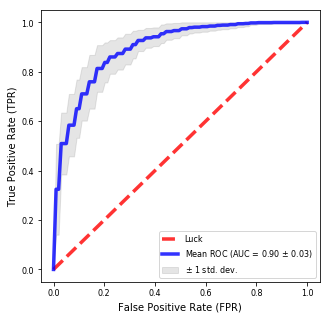

In [76]:
cv_auc(table_protein,clf_protein,random_state,iterations=10,name="protein-specific")

# Visualize feature importance (Figure S1c)

### random

In [77]:
d_scores = {"ASA_SCORE":"S.A.","FCONS_SCORE":"FCONS","COIL":"COIL","HELIX":"HELIX","STRAND":"SHEET","DSS_SCORE":"DISORDER","RIG_SCORE":"RIGIDITY","ANCHOR_SCORE":"ANCHOR","Domain_pfam":"DOMAIN","nflanking_ub_lysines":"UB_SITES","nflanking_ptms":"PHOSPHO_SITES"}
covariate_names = [d_scores[covariate] for covariate in covariates]

In [78]:
clf_random = RandomForestClassifier(n_estimators=10000, random_state=random_state)
clf_random.fit(table_random[covariates], table_random[response_var])
importances = clf_random.feature_importances_
indices = np.argsort(clf_random.feature_importances_)[::-1]
std = np.var([tree.feature_importances_ for tree in clf_random.estimators_],
             axis=0)
for f in range(table_random[covariates].shape[1]):
    print("%s. Feature %s (%f)" % (f + 1, covariate_names[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(4,4))
plt.title("Feature importances")
plt.bar(range(table_random[covariates].shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(table_random[covariates].shape[1]), [d_scores[covariates[i]] for i in indices],rotation=90,fontsize=8)
plt.xlim([-1, table_random[covariates].shape[1]])
plt.savefig(path_output_plots+"/Figure_S1c_feature_importance.pdf", dpi=800,bbox_inches="tight")
#plt.show()

1. Feature DISORDER (0.184730)
2. Feature ANCHOR (0.134650)
3. Feature RIGIDITY (0.129790)
4. Feature FCONS (0.109240)
5. Feature COIL (0.108885)
6. Feature S.A. (0.091422)
7. Feature PHOSPHO_SITES (0.081628)
8. Feature HELIX (0.068855)
9. Feature SHEET (0.068089)
10. Feature UB_SITES (0.013423)
11. Feature DOMAIN (0.009287)


### background protein

In [79]:
clf_protein = RandomForestClassifier(n_estimators=10000, random_state=random_state)
clf_protein.fit(table_protein[covariates], table_protein[response_var])
importances = clf_protein.feature_importances_
indices = np.argsort(clf_protein.feature_importances_)[::-1]
std = np.var([tree.feature_importances_ for tree in clf_protein.estimators_],
             axis=0)
for f in range(table_protein[covariates].shape[1]):
    print("%s. Feature %s (%f)" % (f + 1, covariate_names[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(4,4))
plt.title("Feature importances")
plt.bar(range(table_protein[covariates].shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(table_protein[covariates].shape[1]), [d_scores[covariates[i]] for i in indices],rotation=90,fontsize=8)
plt.xlim([-1, table_protein[covariates].shape[1]])
plt.savefig(path_output_plots+"/Figure_S1c_feature_importance_protein.pdf", dpi=800,bbox_inches="tight")


1. Feature FCONS (0.196338)
2. Feature DISORDER (0.154604)
3. Feature S.A. (0.120145)
4. Feature RIGIDITY (0.106653)
5. Feature ANCHOR (0.091627)
6. Feature COIL (0.086575)
7. Feature SHEET (0.085533)
8. Feature HELIX (0.073204)
9. Feature PHOSPHO_SITES (0.052964)
10. Feature DOMAIN (0.017814)
11. Feature UB_SITES (0.014544)


# Visualize precision/recall curves 

In [80]:
def get_labels(probabilities,threshold):
    prob_degron = [l[1] for l in probabilities]
    labels = [1.0 if prob >= threshold else 0.0 for prob in prob_degron]
    return labels
def get_precision_recall_degron(reals,predicted):
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    i = 0
    
    for real in reals:
        
        if real == 1.0: # degron
            if real == predicted[i]:
                tp+=1
            else:
                fn+=1
        else: # class random
            if real == predicted[i]:
                tn+=1
            else:
                fp+=1
        
        i = i +1
    try:
        precision = tp / (tp+fp)
        recall = tp / (tp+fn)
    except ZeroDivisionError:
        return 0,0
        
    return precision,recall
def thresholds(table_training,clf):
    X = table_training[covariates]
    y = table_training[response_var]
    n_samples, n_features = X.shape
    # Add noisy features
    cv = StratifiedKFold(n_splits=5)
    classifier = clf
    thresholds = np.linspace(0, 0.99, 20)
    precision_degron = [list(np.zeros(20)) for l in range(5)]
    precision_random = [list(np.zeros(20)) for l in range(5)]
    recall_degron = [list(np.zeros(20)) for l in range(5)]
    recall_random = [list(np.zeros(20)) for l in range(5)]
    i = 0
    plt.figure(figsize=(4,4))
    for train, test in cv.split(X, y):
        
        clf= classifier.fit(X.iloc[train], y.iloc[train])
        probas = clf.predict_proba(X.iloc[test])
        
        print ("Iteration %d"%(i))
        j = 0
        for threshold in thresholds:
            labels = get_labels(probas,threshold)
            precision,recall = get_precision_recall_degron (y.iloc[test], labels)
            precision_degron[i][j] = precision
            
            recall_degron[i][j] = recall
            j = j +1
            
        plt.plot( thresholds,precision_degron[i], lw=1, alpha=0.3   )
        plt.plot( thresholds,recall_degron[i], lw=1, alpha=0.3  )
        
        i += 1
    mean_precision = []
    std_precision = []
    mean_recall = []
    std_recall = []
    
    for threshold in range(0,20): 
       
        mean_precision.append(np.mean([row[threshold] for row in precision_degron]))
        std_precision.append(np.nanstd([row[threshold] for row in precision_degron]))
        mean_recall.append(np.nanmean([row[threshold] for row in recall_degron]))
        std_recall.append(np.nanstd([row[threshold] for row in recall_degron]))

    plt.plot(thresholds,mean_precision,  color='b',
             label=r'Mean Precision Degron ',
             lw=2, alpha=.8)
    plt.plot( thresholds,mean_recall, color='r',
             label=r'Mean Recall Degron ',
             lw=2, alpha=.8)

    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Thresholds')
    plt.ylabel('Precision/Recall')
    plt.title('Precision/Recall of degron class per threshold')
    plt.legend(loc="lower right")
    
    plt.savefig(path_output_plots+'/FigureS1d_thresholds_precision.pdf', dpi=800,bbox_inches="tight")
    plt.show()
    

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4


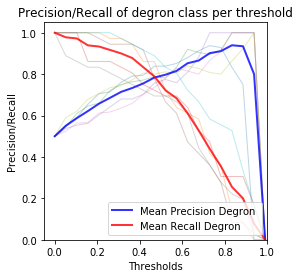

In [81]:
thresholds(table_random,clf_random)


### Evaluate the model using an external test-set

In [82]:
covariates =["ASA_SCORE","DSS_SCORE","FCONS_SCORE","COIL","ANCHOR_SCORE","nflanking_ptms","nflanking_ub_lysines","HELIX","STRAND","RIG_SCORE","Domain_pfam"]
covariates_names = {"Z_ASA":"S.A.","Z_FCONS":"FCONS","Z_SS_C":"COIL","Z_SS_H":"HELIX","Z_SS_E":"SHEET","Z_DSS":"DISORDER","Z_RIG":"RIGIDITY","Z_ANCHOR":"ANCHOR","Z_DOMAIN":"DOMAIN","Z_FLANKING_UB_LYSINE":"UB_SITES","Z_PTMS":"PHOSPHO_SITES"}
response_var = "IS_DEGRON"

##### Load it and calculate features

In [83]:
df_test = pd.read_csv("/workspace/projects/ubiquitins/codereview/degradation/data/test_set.tsv",sep="\t")
from calculate_biochemical_properties import calculate_biochemical_properties
# Positive test-set
df_test_properties_positive = calculate_biochemical_properties(df_test[["Entry","Entry_Isoform","START","END","DEGRON"]].drop_duplicates(),simulations=True,simulated_path=path_simulated_random,lysines=(3,20),ptms=11)
df_test_properties_positive[response_var] = 1.0
df_test_properties_positive[df_test_properties_positive["CONS_SCORE"]>0]
# Negative test-set
N = df_test_properties_positive.shape[0]
seleted_rows = [df_simulated.sample(n=df_test_properties_positive.shape[0])]
df_test_negative = pd.concat(seleted_rows)
df_test_negative_properties = calculate_biochemical_properties(df_test_negative[["Entry","Entry_Isoform","START","END","DEGRON"]].drop_duplicates(),simulations=True,simulated_path=path_simulated_random,lysines=(3,20),ptms=11)
df_test_negative_properties[response_var] = 0.0
df_test_total = pd.concat([df_test_properties_positive,df_test_negative_properties])

### Evaluate the test-set

In [88]:
clf_random.fit(table_random[covariates], table_random[response_var])
predicted_labels = clf_random.predict(df_test_total[covariates])
predicted_probs = clf_random.predict_proba(df_test_total[covariates])
true_labels = df_test_total[response_var].values


In [89]:
df_test_total["Prob_DEGRON"] = [x[1] for x in predicted_probs]
df_test_total["Prob_RANDOM"] = [x[0] for x in predicted_probs]
df_test_total["Class"] = predicted_labels

##### Stats

##### AUC

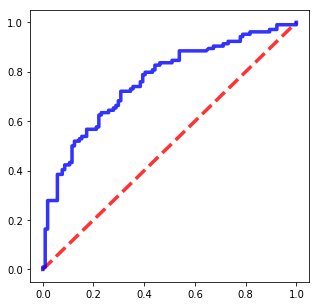

In [90]:
thresholds = np.linspace(0, 0.99, 20)
precision_degron = list(np.zeros(20))
precision_random = list(np.zeros(20))
recall_degron = list(np.zeros(20))
recall_random = list(np.zeros(20))
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs[:,1])
tprs.append(interp(mean_fpr, fpr, tpr))
tprs[-1][0] = 0.0
roc_auc = auc(fpr, tpr)
aucs.append(roc_auc)
fig,ax = plt.subplots(figsize=(5,5))
ax.plot([0, 1], [0, 1], linestyle='--', lw=3.5, color='r',
         label='Luck', alpha=.8)
ax.plot(fpr, tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (np.nanmean(aucs),np.nanstd(aucs)),
         lw=3.5, alpha=.8)


In [91]:
roc_auc

0.7625277366863905

In [92]:
df_test_total[df_test_total["Entry"]=="P10721"]

Entry Entry_Isoform DEGRON  START  END  ASA_SCORE  CONS_SCORE  \
12  P10721      P10721-1    CBL    931  941  63.763636    0.431463   
13  P10721      P10721-1    CBL    563  573  54.100000    0.487105   

    FCONS_SCORE      COIL     HELIX  ...     Z_RIG  Z_ANCHOR  Z_DOMAIN  \
12     1.099126  0.542091  0.411818  ... -0.178518  0.160482 -0.602553   
13     0.969842  0.459182  0.029091  ...  0.547265 -0.816689 -0.602553   

    Z_FLANKING_UB_LYSINE  Z_FLANKING_LYSINE    Z_PTMS IS_DEGRON  Prob_DEGRON  \
12             -0.376789           1.138974  2.742516       1.0       0.8499   
13             -0.376789           1.706942  2.742516       1.0       0.0780   

   Prob_RANDOM  Class  
12      0.1501    1.0  
13      0.9220    0.0  

[2 rows x 38 columns]

### Dummy features

##### For each feature in the classifier create a dummy highly correlated feature

In [93]:
operations = [lambda x: np.log(x),lambda x: np.power(x,2), lambda x: x*2, lambda x: x+np.random.randint(-5,5)]
l_dummy_features = []
for covariate in covariates:
    if covariate == "nflanking_ptms" or covariate == "nflanking_ub_lysines" or covariate == "Domain_pfam":
        selected_op = operations[np.random.randint(2,3)]
    else:
        selected_op = operations[np.random.randint(0,3)]
    l_dummy_features.append(list(map(selected_op,list(table_random[covariate].values))))
matrix = np.matrix(l_dummy_features).T
series = pd.DataFrame(matrix,columns=["dummy_"+covariate for covariate in covariates]) 
table_random[["dummy_"+covariate for covariate in covariates]]= series
dummy_co = ["dummy_"+covariate for covariate in covariates]

Iteration 0
              precision    recall  f1-score   support

      Degron       0.89      0.67      0.76        36
      Random       0.73      0.92      0.81        36

   micro avg       0.79      0.79      0.79        72
   macro avg       0.81      0.79      0.79        72
weighted avg       0.81      0.79      0.79        72

Iteration 1
              precision    recall  f1-score   support

      Degron       0.90      0.78      0.84        36
      Random       0.80      0.92      0.86        36

   micro avg       0.85      0.85      0.85        72
   macro avg       0.85      0.85      0.85        72
weighted avg       0.85      0.85      0.85        72

Iteration 2
              precision    recall  f1-score   support

      Degron       0.83      0.83      0.83        36
      Random       0.83      0.83      0.83        36

   micro avg       0.83      0.83      0.83        72
   macro avg       0.83      0.83      0.83        72
weighted avg       0.83      0.83     

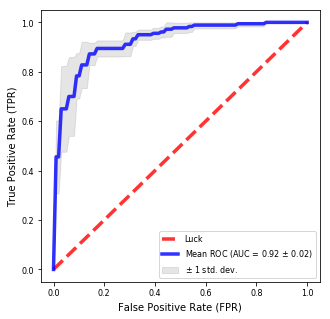

In [94]:
clf_random.fit(table_random[covariates+dummy_co], table_random[response_var])
cv_auc(table_random,clf_random,random_state,iterations=1,name="dummy-covariates")